In [1]:
import sys
from pathlib import Path
src_path = Path.cwd().parent / 'src'
sys.path.append(str(src_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from data_loader import load_data

# Set up data paths
data_path = Path.cwd().parent / "data" / "ag_news"
train_path = data_path / "train.csv"
test_path = data_path / "test.csv"

# Load training data
df_train = load_data(train_path)
X_train = (df_train["Title"] + " " + df_train["Description"]).values
y_train = df_train["Class Index"].values

# Load test data
df_test = load_data(test_path)
X_test = (df_test["Title"] + " " + df_test["Description"]).values
y_test = df_test["Class Index"].values

# Show training data
# df_train.head()

# Show test data
# df_test.head()


In [3]:
from vectorizer import vectorize_data_fit
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize data
vectorizer = TfidfVectorizer()
X_train_vect = vectorize_data_fit(vectorizer, X_train)

In [4]:
from model_trainer import train_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression Model
lg_model = LogisticRegression()
#lg_trained_model = train_model(lg_model, X_train_vect, y_train)

# Train Naive Bayes Model
nb_model = MultinomialNB()
nb_trained_model = train_model(nb_model, X_train_vect, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier()
#rf_trained_model = train_model(rf_model, X_train_vect, y_train)

In [5]:
# from perturbation import apply_perturbation

# # Save perturbed data to file

# X_data = X_test[:1000]
# level = 1.0

# perturbed_data = apply_perturbation(
#     X_data,
#     level,
#     save_path=f"perturbed_data/deletion/perturbed_data_{level:.2f}.pkl"
# )



*** Results Per Perturbation Level


,perturbation level,accuracy,RS,mCE,PDR,MDS
0,0.1,0.844,1.000000,0.0,0.000000,NaN
1,0.2,0.807,0.956161,0.0,0.043839,NaN
2,0.3,0.755,0.894550,0.0,0.105450,1.405405
3,0.4,0.730,0.864929,0.0,0.135071,0.561798
4,0.5,0.679,0.804502,0.0,0.195498,1.342105
5,0.6,0.631,0.747630,0.0,0.252370,1.163636
6,0.7,0.591,0.700237,0.0,0.299763,0.938967
7,0.8,0.570,0.675355,0.0,0.324645,0.498024
8,0.9,0.521,0.617299,0.0,0.382701,1.251825
9,1.0,0.431,0.510664,0.0,0.489336,2.229102


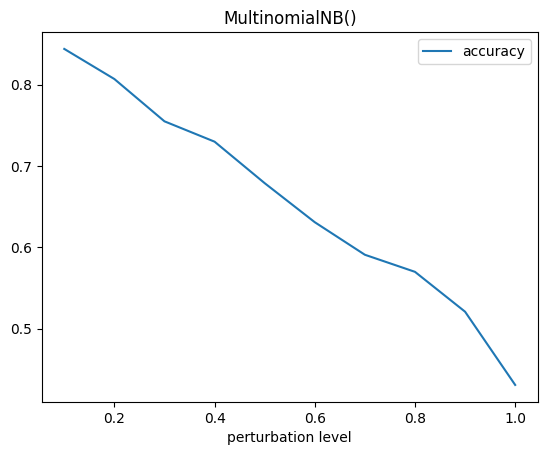

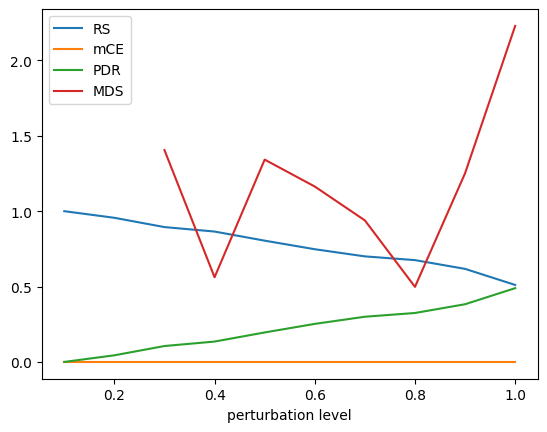

In [8]:
from evaluator import evaluate_robustness

# Evaluation pipeline

# Number of samples to evaluate
X_sample = X_test[:1000]
y_sample = y_test[:1000]

# Define perturbation levels to test
perturbation_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Add required metrics to evaluate
metrics = ["base_accuracy", "robustness_score", "effective_robustness", "mce", "pdr", "our_metric"]

# Use filepath when using pertrubed data from files for faster testing
file_path = Path("perturbed_data/charswap")

# Add model to evaluate (also used for plotting)
model = nb_trained_model

results, metrics_summary = evaluate_robustness(
    model,
    vectorizer,
    X_sample, 
    y_sample,
    perturbation_levels,
    metrics,
    file_path
)

# Do we need metric summary? - info given in table for each level instead
# print("*** Metrics Summary ***")
# for metric, value in metrics_summary.items():
#     print(f"{metric}: {value: .4f}")

results_df = pd.DataFrame(results)
print("*** Results Per Perturbation Level")
display(results_df)



# testing plotting
# todo:
# plot all models on same
# for each perturbation type
# for each model, show metrics responding to pert more? 
results_df.plot(x="perturbation level", y="accuracy", kind="line")
plt.title(str(model))
plt.show()


# plotting all metrics
results_df.plot(x="perturbation level", y=["RS", "mCE", "PDR", "MDS"], kind="line")
plt.show()